In this workbook we use the stationary distribution of a Markov chain to compute relative trend signals and rebalance a basket of assets. Here we imagine an investor bounces from asset to asset based on return. This populates our transition matrix. We ensure the matrix is ergodic with the PageRank dampening factor. Here we can say either our investor is irrational and with a certain probability will jump to another asset for no reason or we can say we only want our assets to fight for x% of the allocation. Either way an ergodic matrix assures the stationary distribution will converge. We compute a trailing stationary distribution based on multiple lookbacks; this is both our trend signal and allocation. bscottwyoming@gmail.com

In [171]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime
import time
import requests
import io

In [136]:
# create a function that downloads price data for a basket of assets
def priceDataFrame(tickers, start, end):
    
    # create empty dataframe
    tickers_stacked = pd.DataFrame()
    # iterate over each symbol
    for i in tickers:  

        try:
            # download the stock price 
            stock = []
            stock = yf.download(i,start=start, end=end, progress=False)

            # append the individual stock prices 
            if len(stock) == 0:
                None
            else:
                stock['Name']=i
                tickers_stacked = tickers_stacked.append(stock,sort=False)
        except Exception:
            None
            
    return tickers_stacked

In [137]:
# create a fuction to build list of substate lists
def substateList(prices, returnlookback, transitionlookback):
    
    #compute returns matrix
    prices['Return'] = prices.groupby('Name')['Adj Close'].pct_change(returnlookback)
    for_returns = pd.pivot_table(data=prices,index=['Date'],columns=['Name'],values=['Return'])
    for_returns = for_returns.dropna()

    
    # make list of daily state
    allstates = pd.DataFrame(for_returns.apply(lambda x: x.argmax(), axis=1))
    allstates.columns =['Row State'] 
    allstates = allstates['Row State'].values.tolist()
    
    # make list of lookback states
    i=0
    substates=[]
    while i < len(allstates) - transitionlookback + 1:
        substates.append(allstates[i:i+transitionlookback])
        i+=1

    return substates

In [138]:
# create a function that builds a transition matrix 
def transitionMatrix(statelist, assets):
    
    # gneralize matrix dims
    n = assets
    # instantiate a matrix
    T = [[0]*n for _ in range(n)]
    # populate matrix
    for (i,j) in zip(statelist,statelist[1:]):
        T[i][j] += 1

    #now convert to probabilities:
    for row in T:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    
    T = np.asarray(T, dtype=np.float32)
            
    return T

In [139]:
# create a function that uses PageRank to ensure an ergodic matrix
def ergodicMatrix(transitionmatrix,d: float = 0.85):
    
    n = len(transitionmatrix)
    ones = np.ones((n, n)) 
    dampening1 = np.multiply(((1-d)/n), ones)
    dampening2 = np.multiply(d, transitionmatrix)
    E = np.add(dampening1, dampening2)

    return E

In [140]:
# create a function that gets stationary distribution from ergodic matrix
def stationaryDistribution(ergodicmatrix):
    
    # http://people.duke.edu/~ccc14/sta-663-2016/homework/Homework02_Solutions.html
    # Left eigenvector with eigenvalue 1
    # note transpose of P to find left eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(ergodicmatrix.T)
    # find index of eigenvalue = 1
    idx = np.argmin(np.abs(eigenvalues - 1))
    w = np.real(eigenvectors[:, idx]).T
    # remember to normalize eigenvector to get a probability distribution
    s = w/np.sum(w)
    
    return s

Here we can imagine some kind diversified global public equities mandate. Here we choose US large cap, US small cap, EAFE, and EM. There would be some kind of target and constraints but it’s not hard to figure out how to map relative trend signals to a range. But here we let these four assets fight for all of the allocation and we do so by setting the dampening factor close to 1. 

In [180]:
# build a portfolio
start = datetime.datetime(2000,1,1)
end = datetime.datetime(2021,2,22)
tickers = ['EEM','EFA','IWM','SPY']

prices = priceDataFrame(tickers, start, end)

In [181]:
# create list of substate lists
substates = substateList(prices, 5, 33)

In [182]:
# compute stationary distrubution of all substate lists
assets = len(tickers)
damp = 0.50

historicalstationarydist = []
for i in substates:

    T = transitionMatrix(i,assets)
    E = ergodicMatrix(T, damp)
    s = stationaryDistribution(E)
    historicalstationarydist.append(s)

In [183]:
prices_timeseries = pd.pivot_table(data=prices,index=['Date'],columns=['Name'],values=['Adj Close'])
prices_timeseries = prices_timeseries.dropna()

In [184]:
historicalstationarydist = pd.DataFrame(historicalstationarydist,columns = prices_timeseries.columns)

In [185]:
nanrows = len(prices_timeseries) - len(historicalstationarydist)
plug = pd.DataFrame(columns=historicalstationarydist.columns, index=range(nanrows))
plug_sd = pd.concat([plug,historicalstationarydist], axis=0)
len(plug_sd)

4495

In [187]:
historical_sd = pd.concat([prices_timeseries,plug_sd], axis=0)
historical_sd.to_csv(r'C:/Users/bscot/OneDrive/Documents//Python Trend/historical_sd.csv', index = True, header=True)

For now we export daily stationary distributions to easily manipulate dataframes and charts in another environment. We fashion a crude backtest with daily returns where Markov portfolio return at time t is based on the stationary distribution computed at time t-2--so we are two closes behind. We compare this to a portfolio with an equal weighted allocation that rebalances the same frequency. The below charts show the NAV of these two strategies plus the strength of trend signals alongside their associated asset. The Markov strategy is just about the same as the equally weighted approach. There exists more nuanced analysis of these results but we exclude that here. 

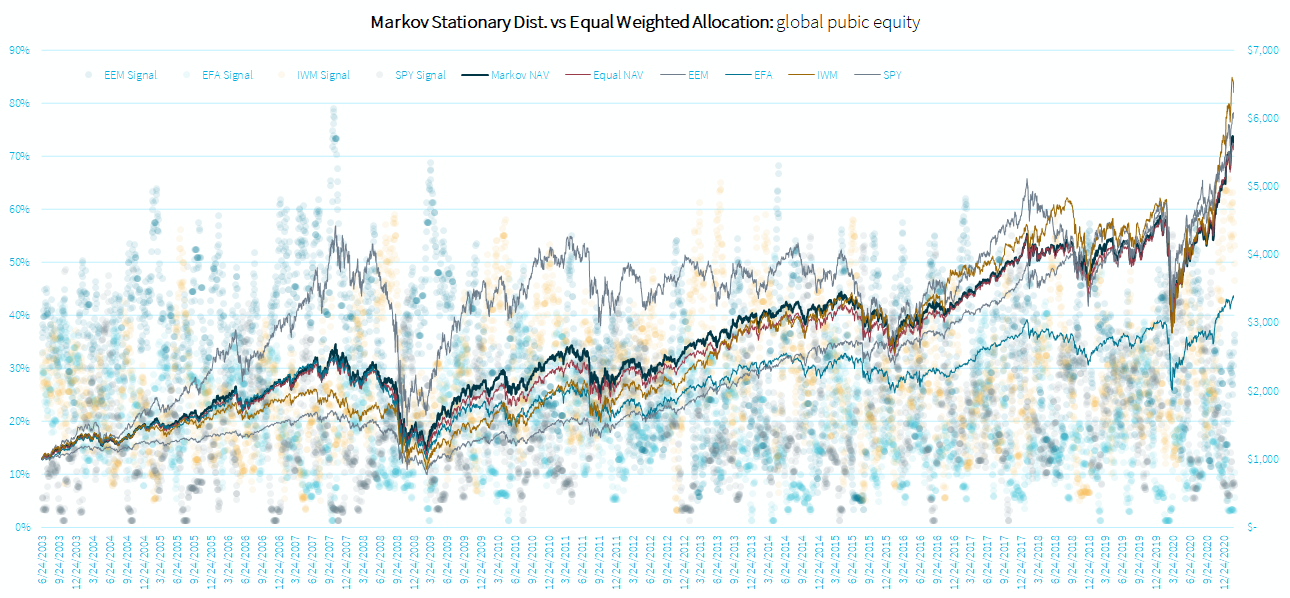

Markov	Equal	EEM	EFA	IWM	SPY

Min	-11.98%	-11.75%	-16.17%	-11.16%	-13.27%	-10.94%

Max	14.60%	15.45%	22.77%	15.89%	9.15%	14.52%

Mean	0.05%	0.05%	0.06%	0.04%	0.05%	0.05%

Median	0.11%	0.10%	0.11%	0.08%	0.11%	0.07%

Sigma	22.87%	22.14%	29.10%	21.79%	24.07%	19.02%

CAGR	10.36%	10.23%	10.23%	10.73%	7.13%	11.20%

Sharpe	0.45	0.46	0.35	0.49	0.30	0.59